# Finish Here
# 3rd Notebook

In [136]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread 
import seaborn as sns
import statsmodels.api as sm
from PIL import Image
import os

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, log_loss
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Neural network libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.layers import Dense, Dropout, Flatten, LayerNormalization
from tensorflow.keras.utils import to_categorical

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices, dmatrix, demo_data

%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

### Reading in Data

In [2]:
df= pd.read_csv('/Users/meiralelov/Documents/Flatiron/Projects/natural_product_classifier/notebooks/datasetnew.tsv', sep='\t')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df

,ChEBI,MolecularFormula,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,...,Rn,Fr,Ra,Ac,Th,Pa,U,FCharge,RoleType,RoleName
0,19032,C2H4BrCl,143.410,1.6,NaN,NaN,0.0,10.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,mutagen
1,21182,C23H30Cl5N3O,541.800,NaN,NaN,NaN,37.4,494.0,NaN,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,intercalator
2,21183,C21H27Cl4N3O,479.300,NaN,NaN,NaN,37.4,442.0,NaN,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,intercalator
3,28925,C5H11Cl2N,156.050,0.9,NaN,NaN,3.2,43.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,alkylating agent
4,40910,N3-,42.021,1.5,NaN,NaN,3.0,15.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,biological role,mitochondrial respiratory-chain inhibitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,131528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10484,90785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,bacterial metabolite
10485,77774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,biological role,phosphodiesterase IV inhibitor
10486,83335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,application,antifungal agrochemical


In [3]:
df.MolecularFormula.duplicated().sum()

3818

In [4]:
df.drop(['MolecularFormula'], axis=1, inplace=True)

### Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10488 entries, 0 to 10487
Columns: 114 entries, ChEBI to RoleName
dtypes: float64(111), int64(1), object(2)
memory usage: 9.1+ MB


In [6]:
df.dtypes

ChEBI                 int64
MolecularWeight     float64
XLogP               float64
ExactMass           float64
MonoisotopicMass    float64
                     ...   
Pa                  float64
U                   float64
FCharge             float64
RoleType             object
RoleName             object
Length: 114, dtype: object

In [7]:
df.describe()

,ChEBI,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,FCharge
count,10488.000000,10136.000000,9460.000000,0.0,0.0,10136.000000,10136.000000,0.0,10136.000000,10136.000000,...,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.0,10136.000000
mean,74864.215103,416.048117,2.137970,NaN,NaN,124.505397,611.892463,NaN,3.508287,7.122534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.051500
std,50620.763215,298.143413,5.906588,NaN,NaN,123.788034,581.067692,NaN,4.424729,7.113387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522708
min,25.000000,2.016000,-24.300000,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.000000
25%,51472.250000,222.370000,-0.800000,NaN,NaN,55.800000,246.000000,NaN,1.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,70862.000000,343.370000,2.000000,NaN,NaN,92.400000,468.000000,NaN,2.000000,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,86392.250000,501.600000,4.500000,NaN,NaN,150.000000,797.000000,NaN,4.000000,8.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,744019.000000,4541.000000,40.400000,NaN,NaN,2040.000000,11900.000000,NaN,71.000000,111.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000


In [8]:
df.isnull().sum()

ChEBI                   0
MolecularWeight       352
XLogP                1028
ExactMass           10488
MonoisotopicMass    10488
                    ...  
Pa                    352
U                     352
FCharge               352
RoleType                0
RoleName                0
Length: 114, dtype: int64

In [9]:
df.index.duplicated().sum()

0

In [10]:
df.duplicated().sum()

0

In [11]:
df.shape

(10488, 114)

### Data Cleaning

In [12]:
cols = list(df.columns)

def null_percentage(df, cols):
    
    list_of_percentages = []
    
    for i in cols:
        
        percent = ((df[i].isna().sum())/(len(df))) * 100
    
        list_of_percentages.append(percent)
        
    zip_list = zip(cols, list_of_percentages)   

    return zip_list

# I would like to visualize the percentage specifically associated with each column

In [13]:
list(null_percentage(df, cols))

[('ChEBI', 0.0),
 ('MolecularWeight', 3.3562166285278416),
 ('XLogP', 9.801678108314265),
 ('ExactMass', 100.0),
 ('MonoisotopicMass', 100.0),
 ('TPSA', 3.3562166285278416),
 ('Complexity', 3.3562166285278416),
 ('Charge', 100.0),
 ('HBondDonorCount', 3.3562166285278416),
 ('HBondAcceptorCount', 3.3562166285278416),
 ('RotatableBondCount', 3.3562166285278416),
 ('HeavyAtomCount', 3.3562166285278416),
 ('IsotopeAtomCount', 100.0),
 ('AtomStereoCount', 100.0),
 ('DefinedAtomStereoCount', 100.0),
 ('UndefinedAtomStereoCount', 100.0),
 ('BondStereoCount', 100.0),
 ('H', 3.3562166285278416),
 ('He', 3.3562166285278416),
 ('Li', 3.3562166285278416),
 ('Be', 3.3562166285278416),
 ('B', 3.3562166285278416),
 ('C', 3.3562166285278416),
 ('N', 3.3562166285278416),
 ('O', 3.3562166285278416),
 ('F', 3.3562166285278416),
 ('Ne', 3.3562166285278416),
 ('Na', 3.3562166285278416),
 ('Mg', 3.3562166285278416),
 ('Al', 3.3562166285278416),
 ('Si', 3.3562166285278416),
 ('P', 3.3562166285278416),
 ('S',

In [14]:
null_list = list(null_percentage(df, cols))

for x in null_list:
    
    if x[1].astype(float) < 5:

        df.dropna(axis=0,subset=[x[0]], inplace=True)  

In [15]:
null_list = list(null_percentage(df, cols))
null_list

[('ChEBI', 0.0),
 ('MolecularWeight', 0.0),
 ('XLogP', 6.669297553275453),
 ('ExactMass', 100.0),
 ('MonoisotopicMass', 100.0),
 ('TPSA', 0.0),
 ('Complexity', 0.0),
 ('Charge', 100.0),
 ('HBondDonorCount', 0.0),
 ('HBondAcceptorCount', 0.0),
 ('RotatableBondCount', 0.0),
 ('HeavyAtomCount', 0.0),
 ('IsotopeAtomCount', 100.0),
 ('AtomStereoCount', 100.0),
 ('DefinedAtomStereoCount', 100.0),
 ('UndefinedAtomStereoCount', 100.0),
 ('BondStereoCount', 100.0),
 ('H', 0.0),
 ('He', 0.0),
 ('Li', 0.0),
 ('Be', 0.0),
 ('B', 0.0),
 ('C', 0.0),
 ('N', 0.0),
 ('O', 0.0),
 ('F', 0.0),
 ('Ne', 0.0),
 ('Na', 0.0),
 ('Mg', 0.0),
 ('Al', 0.0),
 ('Si', 0.0),
 ('P', 0.0),
 ('S', 0.0),
 ('Cl', 0.0),
 ('A', 0.0),
 ('K', 0.0),
 ('Ca', 0.0),
 ('Sc', 0.0),
 ('Ti', 0.0),
 ('Ti.1', 0.0),
 ('V', 0.0),
 ('Cr', 0.0),
 ('Mn', 0.0),
 ('Fe', 0.0),
 ('Co', 0.0),
 ('Ni', 0.0),
 ('Cu', 0.0),
 ('Zn', 0.0),
 ('Ga', 0.0),
 ('Ge', 0.0),
 ('As', 0.0),
 ('Se', 0.0),
 ('Br', 0.0),
 ('Kr', 0.0),
 ('Rb', 0.0),
 ('Sr', 0.0),
 (

In [16]:
df.shape

(10136, 114)

In [17]:
clean_df = df.drop(['ExactMass', 'MonoisotopicMass', 'Charge', 'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount','UndefinedAtomStereoCount', 'BondStereoCount'], axis=1)

In [18]:
clean_df.XLogP.isnull().value_counts()

False    9460
True      676
Name: XLogP, dtype: int64

In [19]:
clean_df[pd.isnull(clean_df.XLogP)].RoleType.value_counts()

application        358
biological role    266
chemical role       52
Name: RoleType, dtype: int64

In [20]:
clean_df.XLogP.value_counts().sort_values()
#because domain knowledge of XLogP is that values all have a significance, we can't assign 0 as a neutral value.
#instead, we will asign most frequent as neutral value.
#because the number of nulls associataed with XLogP is 676, which is 5 times the amount of the most frequent value,
#we can't simply add it, but rather we need to bin. Otherwise, the most frequent class will be a lot more frequent. 
#1.5 is most frequent, and the top 5 most frequent values are close enough to one another. 
#I can add values to the most frequent class without the data being affected more. 

-24.3      1
 22.3      1
 24.8      1
 23.0      1
 26.4      1
        ... 
 2.4     115
 2.1     115
 2.5     119
 2.0     121
 1.5     129
Name: XLogP, Length: 418, dtype: int64

In [21]:
ser, bins= pd.qcut(clean_df.XLogP, retbins=True, q=5)

In [22]:
ser.value_counts()

(-24.301000000000002, -1.8]    1926
(-1.8, 1.0]                    1906
(5.2, 40.4]                    1890
(2.8, 5.2]                     1887
(1.0, 2.8]                     1851
Name: XLogP, dtype: int64

In [23]:
bins

array([-24.3,  -1.8,   1. ,   2.8,   5.2,  40.4])

In [24]:
clean_df['XLogP_qcut'] = pd.cut(clean_df.XLogP, bins=bins, labels=False)
clean_df.drop('XLogP', axis=1, inplace=True)
clean_df.XLogP_qcut.value_counts()

0.0    1925
1.0    1906
4.0    1890
3.0    1887
2.0    1851
Name: XLogP_qcut, dtype: int64

In [25]:
cols = list(clean_df.columns.values) #Make a list of all of the columns in the df

cols.pop(cols.index('RoleType')) #Remove b from list
cols.pop(cols.index('RoleName')) #Remove x from list

clean_df = clean_df[cols+['RoleType','RoleName']] #Create new dataframe with columns in the order you want

In [26]:
clean_df.XLogP_qcut.fillna(value=2, inplace=True)
clean_df.XLogP_qcut.value_counts()
#this way, there is not as much of class imbalance

2.0    2528
0.0    1925
1.0    1906
4.0    1890
3.0    1887
Name: XLogP_qcut, dtype: int64

In [27]:
clean_df.shape

(10136, 106)

# Role Type Classification

## Role Type Data

In [28]:
clean_df.RoleType.value_counts()

biological role    8641
application        1329
chemical role       166
Name: RoleType, dtype: int64

In [29]:
bio_rt_df = clean_df[clean_df['RoleType'] == 'biological role']
chem_rt_df = clean_df[clean_df['RoleType'] == 'chemical role']
app_rt_df = clean_df[clean_df['RoleType'] == 'application']

#upsample the minority class and downsample majority
chem_rt_df = resample(chem_rt_df, random_state=42, n_samples=1500, replace=True)
bio_rt_df = resample(bio_rt_df, random_state=42, n_samples=2500, replace=False)

balanced_rt_df = pd.concat([bio_rt_df, chem_rt_df, app_rt_df])
balanced_rt_df.RoleType.value_counts()

biological role    2500
chemical role      1500
application        1329
Name: RoleType, dtype: int64

In [30]:
balanced_rt_df.shape

(5329, 106)

In [31]:
balanced_rt_df

,ChEBI,MolecularWeight,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,H,He,...,Fr,Ra,Ac,Th,Pa,U,FCharge,XLogP_qcut,RoleType,RoleName
9870,143237,232.21,109.0,330.0,2.0,6.0,3.0,15.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,biological role,mouse metabolite
5696,77996,563.90,69.6,574.0,3.0,3.0,31.0,40.0,69.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,biological role,mouse metabolite
814,545687,228.28,74.6,233.0,2.0,4.0,10.0,16.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,biological role,plant hormone
5085,18040,162.19,110.0,129.0,4.0,5.0,5.0,11.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,human metabolite
923,59415,540.50,271.0,843.0,9.0,15.0,10.0,37.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,biological role,epitope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10438,189588,166.17,39.4,175.0,0.0,3.0,4.0,12.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,flavouring agent
10439,82038,347.32,112.0,463.0,1.0,9.0,7.0,25.0,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,herbicide
10441,189672,363.40,122.0,567.0,3.0,5.0,5.0,25.0,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,herbicide safener
10442,173589,140.20,45.3,122.0,0.0,2.0,1.0,9.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,application,flavouring agent


### Creating Helper Functions

In [32]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 5)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
    

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax)

        return ax

#taken from David Elliot's lecture on classification workflow

### Role Type Train-Test Split

In [33]:
X = balanced_rt_df.drop(['RoleType', 'RoleName', 'ChEBI'], axis=1)
y = balanced_rt_df['RoleType']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Role Type Modelling

In [34]:
def grab_numeric_rt(df):
    return df.select_dtypes(include=['float', 'int'])

GrabNumeric_rt = FunctionTransformer(grab_numeric_rt)

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric_rt),
                              ('ss', StandardScaler())])

ct = ColumnTransformer(transformers = [('subpipe_num', subpipe_num, X_train.columns),])

### Baseline Model

In [35]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X_train, y_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X_train,
    y=y_train)

CV Results for `dummy_model_pipe` model:
            0.46897 ± 0.00050 accuracy
        
 Train: 0.46896896896896895


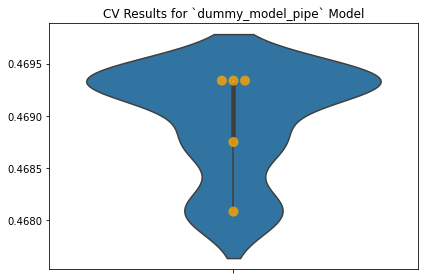

In [36]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


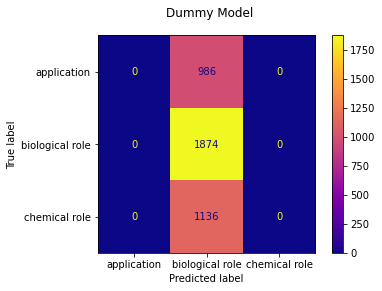

In [37]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_pipe, X_train, y_train, ax=ax, cmap="plasma");

### Logistic Regression

In [38]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X_train, y_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X_train, 
                       y=y_train)

CV Results for `log_pipe` model:
            0.63389 ± 0.00769 accuracy
        
 Train: 0.6371371371371372


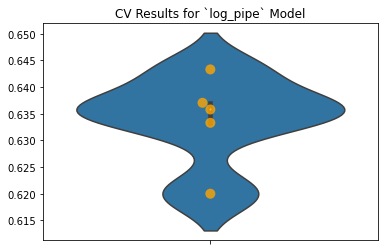

In [39]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


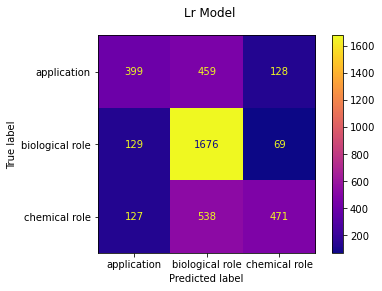

In [40]:
fig, ax = plt.subplots()

fig.suptitle("Lr Model")

plot_confusion_matrix(logreg_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

#plot_roc_curve(logreg_model_pipe, X_train, y_train);

### Decision Trees

In [41]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X_train, y_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `dt_pipe` model:
            0.78929 ± 0.00666 accuracy
        
 Train: 0.9972472472472472


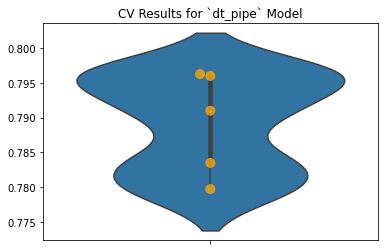

In [42]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


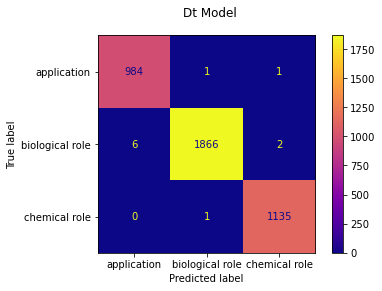

In [43]:
fig, ax = plt.subplots()

fig.suptitle("Dt Model")

plot_confusion_matrix(dt_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

#plot_roc_curve(dt_model_pipe, X_train, y_train);

### Random Forest

In [129]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42))])

rfc_model_pipe.fit(X_train, y_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe',
                          X=X_train, 
                          y=y_train)

CV Results for `forest_pipe` model:
            0.85811 ± 0.01189 accuracy
        
 Train: 0.9972472472472472


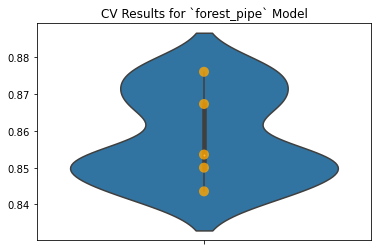

In [130]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


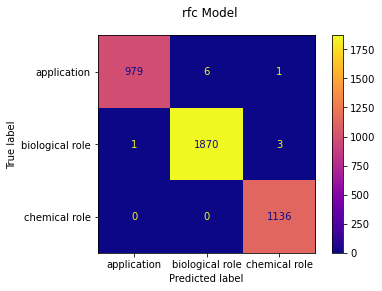

In [131]:
fig, ax = plt.subplots()

fig.suptitle("rfc Model")

plot_confusion_matrix(rfc_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

#plot_roc_curve(rfc_model_pipe, X_train, y_train);

### KNeighborsClassifier

In [132]:
knn_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('knn', KNeighborsClassifier())])

knn_model_pipe.fit(X_train, y_train)

knn_pipe = ModelWithCV(model=knn_model_pipe,
                         model_name='knn_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `knn_pipe` model:
            0.78603 ± 0.01270 accuracy
        
 Train: 0.8673673673673674


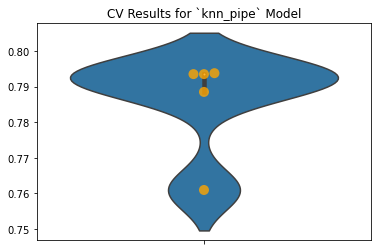

In [48]:
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax=ax);

knn_pipe.print_cv_summary()

train_score = knn_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


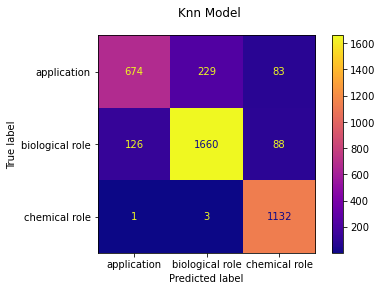

In [49]:
fig, ax = plt.subplots()

fig.suptitle("Knn Model")

plot_confusion_matrix(knn_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### GradientBoostingClassifier

In [90]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X_train, y_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `boost_pipe` model:
            0.77453 ± 0.00809 accuracy
        
 Train: 0.8103103103103103


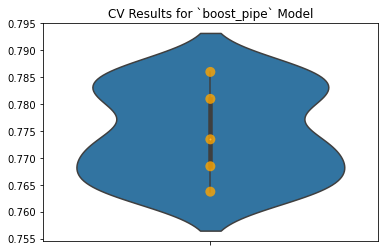

In [91]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X_train, y_train)
print(f' Train: {train_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


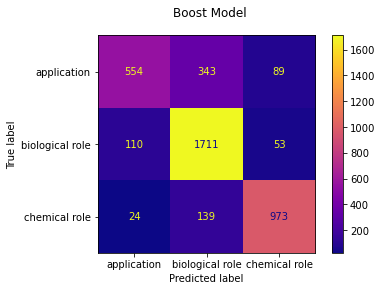

In [92]:
fig, ax = plt.subplots()

fig.suptitle("Boost Model")

plot_confusion_matrix(gbc_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

### Grid Search

In [147]:
params_rfc = {
    'rfc__n_estimators' : [110,115,120],
    'rfc__max_depth' : [19,20,21],}

gs_rfc = GridSearchCV(rfc_model_pipe, 
                      params_rfc, 
                      scoring=['accuracy','neg_log_loss'],
                      refit='accuracy',                  
                      n_jobs=-1, 
                      cv=5, 
                      verbose=3)

gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric_rt at 0x7f7c4012e320>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['MolecularWeight', 'TPSA', 'Complexity', 'HBondDonorCount',
       'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'H', 'He',
       'Li',
       ...
       'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'FCharge', 'XLogP_qcut'],
      dtype='object', length=103))])),
             

In [148]:
print(gs_rfc.best_params_)
print(gs_rfc.best_score_)
pd.DataFrame(gs_rfc.cv_results_)

{'rfc__max_depth': 20, 'rfc__n_estimators': 115}
0.8601113892365457


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_accuracy,rank_test_accuracy,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss
0,0.467840,0.009149,0.050509,0.008811,19,110,"{'rfc__max_depth': 19, 'rfc__n_estimators': 110}",0.85500,0.848561,0.846058,...,0.009984,8,-0.380989,-0.390576,-0.391841,-0.379858,-0.395190,-0.387691,0.006133,9
1,0.476227,0.022327,0.044240,0.002730,19,115,"{'rfc__max_depth': 19, 'rfc__n_estimators': 115}",0.85375,0.849812,0.846058,...,0.009033,9,-0.380887,-0.390048,-0.392542,-0.379072,-0.394799,-0.387470,0.006324,8
2,0.455716,0.045544,0.056033,0.011083,19,120,"{'rfc__max_depth': 19, 'rfc__n_estimators': 120}",0.85500,0.848561,0.846058,...,0.010329,7,-0.380501,-0.390282,-0.391815,-0.377717,-0.395012,-0.387065,0.006731,7
3,0.447939,0.045198,0.051414,0.010465,20,110,"{'rfc__max_depth': 20, 'rfc__n_estimators': 110}",0.85375,0.847309,0.852315,...,0.011898,3,-0.373266,-0.385455,-0.381557,-0.373360,-0.389647,-0.380657,0.006520,4
4,0.449046,0.040481,0.051367,0.007301,20,115,"{'rfc__max_depth': 20, 'rfc__n_estimators': 115}",0.85500,0.849812,0.847309,...,0.013193,1,-0.372199,-0.385304,-0.382002,-0.372455,-0.388286,-0.380049,0.006612,2
5,0.464918,0.018838,0.053060,0.007719,20,120,"{'rfc__max_depth': 20, 'rfc__n_estimators': 120}",0.85625,0.849812,0.849812,...,0.010578,2,-0.371762,-0.385083,-0.381929,-0.373325,-0.388358,-0.380091,0.006508,3
6,0.401122,0.044398,0.060276,0.009257,21,110,"{'rfc__max_depth': 21, 'rfc__n_estimators': 110}",0.84500,0.854819,0.846058,...,0.013006,5,-0.366921,-0.416652,-0.379800,-0.370127,-0.387004,-0.384101,0.017759,6
7,0.471089,0.021003,0.054254,0.006293,21,115,"{'rfc__max_depth': 21, 'rfc__n_estimators': 115}",0.84625,0.856070,0.844806,...,0.013798,4,-0.367039,-0.417082,-0.380182,-0.369226,-0.386495,-0.384005,0.018006,5
8,0.412668,0.008276,0.044841,0.000539,21,120,"{'rfc__max_depth': 21, 'rfc__n_estimators': 120}",0.84750,0.854819,0.847309,...,0.012012,6,-0.367292,-0.383374,-0.380463,-0.368160,-0.386813,-0.377220,0.008013,1


In [149]:
params_gbc = {
    'gbc__n_estimators' : [90,100,110],
    'gbc__max_depth' : [14,15,16]}

gs_gbc = GridSearchCV(gbc_model_pipe, 
                      params_gbc, 
                      scoring=['accuracy','neg_log_loss'],
                      refit='accuracy',  
                      n_jobs=-1, 
                      cv=5, 
                      verbose=3)

gs_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric_rt at 0x7f7c4012e320>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['MolecularWeight', 'TPSA', 'Complexity', 'HBondDonorCount',
       'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 'H', 'He',
       'Li',
       ...
       'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'FCharge', 'XLogP_qcut'],
      dtype='object', length=103))])),
             

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 5/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 5/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 5/5] END rfc__max_depth=20, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 2/5] END rfc__max_depth=21, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.6s
[CV 3/5] END rfc__max_depth=19, rfc__n_estimators=115; accuracy: (test=0.846) neg_log_loss: (test=-0.393) total time=   0.5s
[CV 4/5] END rfc__max_depth=20, rfc__n_estimators=110; accuracy: (test=0.862) neg_log_loss: (test=-0.373) total time=   0.5s
[CV 4/5] END rfc__max_depth=20, rfc__n_estimators=120; accuracy: (test=0.866) neg_log_loss: (test=-0.373) total time=   0.6s
[CV 4/5] END rfc__max_depth=21, rfc__n_estimators=115; ac

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 1/5] END rfc__max_depth=19, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 2/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 1/5] END rfc__max_depth=20, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 2/5] END rfc__max_depth=21, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 2/5] END rfc__max_depth=21, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 3/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=0.846) neg_log_loss: (test=-0.392) total time=   0.5s
[CV 3/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=0.846) neg_log_loss: (test=-0.392) total time=   0.5s
[CV 2/5] END rfc__max_depth=20, rfc__n_e

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 2/5] END rfc__max_depth=19, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.6s
[CV 4/5] END rfc__max_depth=20, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 2/5] END rfc__max_depth=20, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 1/5] END rfc__max_depth=21, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 1/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=0.855) neg_log_loss: (test=-0.381) total time=   0.5s
[CV 1/5] END rfc__max_depth=20, rfc__n_estimators=110; accuracy: (test=0.854) neg_log_loss: (test=-0.373) total time=   0.5s
[CV 4/5] END rfc__max_depth=20, rfc__n_estimators=115; accuracy: (test=0.865) neg_log_loss: (test=-0.372) total time=   0.5s
[CV 1/5] END rfc__max_depth=21, rfc__n_estimators=110; ac

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 5/5] END rfc__max_depth=19, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 3/5] END rfc__max_depth=20, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 4/5] END rfc__max_depth=20, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 4/5] END rfc__max_depth=21, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 1/5] END rfc__max_depth=19, rfc__n_estimators=115; accuracy: (test=0.854) neg_log_loss: (test=-0.381) total time=   0.4s
[CV 1/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=0.855) neg_log_loss: (test=-0.381) total time=   0.5s
[CV 5/5] END rfc__max_depth=20, rfc__n_estimators=115; accuracy: (test=0.884) neg_log_loss: (test=-0.388) total time=   0.5s
[CV 5/5] END rfc__max_depth=21, rfc__n_estimators=110; ac

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 2/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 1/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 2/5] END rfc__max_depth=20, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 3/5] END rfc__max_depth=21, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 1/5] END rfc__max_depth=21, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 2/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=0.849) neg_log_loss: (test=-0.391) total time=   0.4s
[CV 2/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=0.849) neg_log_loss: (test=-0.390) total time=   0.5s
[CV 1/5] END rfc__max_depth=20, rfc__n_e

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 1/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 4/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.6s
[CV 3/5] END rfc__max_depth=20, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 3/5] END rfc__max_depth=21, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 4/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=0.867) neg_log_loss: (test=-0.380) total time=   0.5s
[CV 5/5] END rfc__max_depth=19, rfc__n_estimators=120; accuracy: (test=0.872) neg_log_loss: (test=-0.395) total time=   0.5s
[CV 1/5] END rfc__max_depth=20, rfc__n_estimators=120; accuracy: (test=0.856) neg_log_loss: (test=-0.372) total time=   0.5s
[CV 2/5] END rfc__max_depth=21, rfc__n_estimators=115; ac

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

[CV 4/5] END rfc__max_depth=19, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.5s
[CV 1/5] END rfc__max_depth=20, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 4/5] END rfc__max_depth=20, rfc__n_estimators=115; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 5/5] END rfc__max_depth=21, rfc__n_estimators=110; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 3/5] END rfc__max_depth=21, rfc__n_estimators=120; accuracy: (test=nan) neg_log_loss: (test=nan) precision: (test=nan) total time=   0.4s
[CV 4/5] END rfc__max_depth=19, rfc__n_estimators=115; accuracy: (test=0.865) neg_log_loss: (test=-0.379) total time=   0.4s
[CV 2/5] END rfc__max_depth=20, rfc__n_estimators=110; accuracy: (test=0.847) neg_log_loss: (test=-0.385) total time=   0.5s
[CV 3/5] END rfc__max_depth=20, rfc__n_e

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 1765, in precision_score
    zero_divisi

In [80]:
print(gs_gbc.best_params_)
print(gs_gbc.best_score_)
pd.DataFrame(gs_gbc.cv_results_)

{'gbc__max_depth': 15, 'gbc__n_estimators': 100}
0.8583588861076346


In [119]:
final_rt_model_pipe = gs_rfc.best_estimator_

## Role Type Classification Evaluation

### Final Role Type Model

In [120]:
final_rt_model_pipe.fit(X_train, y_train)

final_rt_pipe = ModelWithCV(model=final_rt_model_pipe,
                         model_name='final_pipe',
                         X=X_train,
                         y=y_train)

CV Results for `final_pipe` model:
            0.86011 ± 0.01319 accuracy
        
 Train: 0.9912412412412412
 Test: 0.8709677419354839


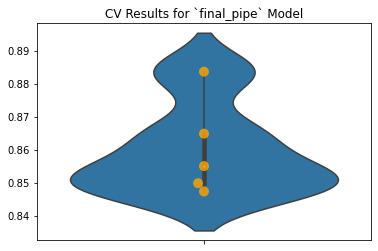

In [121]:
fig, ax = plt.subplots()

final_rt_pipe.plot_cv(ax=ax);

final_rt_pipe.print_cv_summary()

train_score = final_rt_model_pipe.score(X_train, y_train)
test_score = final_rt_model_pipe.score(X_test, y_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/meiralelov/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


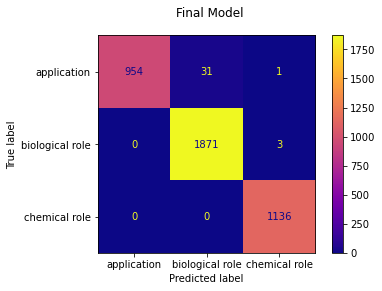

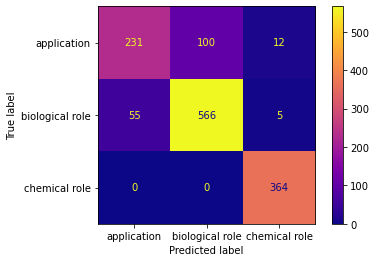

In [122]:
fig, ax = plt.subplots()

fig.suptitle("Final Model")

plot_confusion_matrix(final_rt_model_pipe, X_train, y_train, ax=ax, cmap="plasma");

plot_confusion_matrix(final_rt_model_pipe, X_test, y_test, cmap="plasma");

In [ ]:
y_hat = final_rt_model_pipe.predict(X_test)
print(f'''Final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}''')

## Role Type Feature Importances

In [ ]:
rfc_features = final_rt_model_pipe.named_steps['rfc'].feature_importances_

num_rt_features = grab_numeric_rt(X_train).columns

num_rt_list = list(num_rt_features)

features_rt_df = pd.DataFrame(rfc_features, num_rt_list, columns=['rfc_features'])

features_rt_df.sort_values(by='rfc_features', ascending=False).head(20)

In [ ]:
final_rt_model_pipe.fit(X,y)

final_rt_pipe = ModelWithCV(model=final_rt_model_pipe,
                         model_name='final_pipe',
                         X=X,
                         y=y)

# Role Name Classification

## Role Name Data

In [ ]:
clean_df.shape

In [ ]:
clean_df.RoleName.value_counts()

In [ ]:
clean_df.RoleName

In [ ]:
balanced_rn_df = clean_df[clean_df.groupby('RoleName').RoleName.transform('count')>9]
balanced_rn_df.RoleName.value_counts()

In [ ]:
len(balanced_rn_df.RoleName.value_counts().index)

In [ ]:
bio_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'biological role']
chem_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'chemical role']
app_rn_df = balanced_rn_df[balanced_rn_df['RoleType'] == 'application']

In [ ]:
balanced_rn_df.shape

In [ ]:
balanced_rn_df

In [ ]:
len(bio_rn_df.RoleName.value_counts())

In [ ]:
len(chem_rn_df.RoleName.value_counts())

In [ ]:
len(app_rn_df.RoleName.value_counts())

### Role Name Train-Test Split

In [ ]:
# one role name in one role type between another role name in another role type. 
#this uncertainty in the model could b egiven a hint by the role type. 
#it accounts for 5% more accuracy. however I don't want to provide the training 'hints'
#this is almost cheating because it uses a hierarchical information to inform the lower level of the hierarchy.

In [ ]:
X1 = balanced_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y1 = balanced_rn_df['RoleName']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)

In [ ]:
X2 = bio_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y2 = bio_rn_df['RoleName']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

In [ ]:
X3 = chem_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y3 = chem_rn_df['RoleName']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

In [ ]:
X4 = app_rn_df.drop(['RoleName', 'RoleType', 'ChEBI'], axis=1)
y4 = app_rn_df['RoleName']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=42)

## Role Name Modelling

In [ ]:
def grab_numeric_rn(df):
    return df.select_dtypes(include=['float', 'int'])

GrabNumeric_rn = FunctionTransformer(grab_numeric_rn)

subpipe_num = Pipeline(steps=[('get_num', GrabNumeric_rn),
                              ('ss', StandardScaler())])

ct = ColumnTransformer(transformers = [('subpipe_num', subpipe_num, X.columns)])

### Baseline Model Full Dataframe

In [ ]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X1_train, y1_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X1_train,
    y=y1_train)

In [ ]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Baseline Model Bio

In [ ]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X2_train, y2_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X2_train,
    y=y2_train)

In [ ]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

### Baseline Model Chem

In [ ]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X3_train, y3_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X3_train,
    y=y3_train)

In [ ]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

### Baseline Model App

In [ ]:
dummy_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(strategy='most_frequent'))])

dummy_pipe.fit(X4_train, y4_train)

dummy_model_pipe = ModelWithCV(
    model=dummy_pipe,
    model_name='dummy_model_pipe',
    X=X4_train,
    y=y4_train)

In [ ]:
fig, ax = plt.subplots()

ax = dummy_model_pipe.plot_cv(ax)
plt.tight_layout();

dummy_model_pipe.print_cv_summary()

train_score = dummy_pipe.score(X4_train, y4_train)
print(f' Train: {train_score}')

### Logistic Regression Full Dataframe

In [ ]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X1_train, y1_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X1_train, 
                       y=y1_train)

In [ ]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Logistic Regression Bio

In [ ]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X2_train, y2_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X2_train, 
                       y=y2_train)

In [ ]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

### Logistic Regression Chem

In [ ]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X3_train, y3_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X3_train, 
                       y=y3_train)

In [ ]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

### Logistic Regression App

In [ ]:
logreg_model_pipe = Pipeline(steps=[
                    ('ct',ct),
                    ('lr', LogisticRegression(random_state=42, max_iter=10000))])

logreg_model_pipe.fit(X1_train, y1_train)

log_pipe = ModelWithCV(model=logreg_model_pipe, 
                       model_name = 'log_pipe', 
                       X=X1_train, 
                       y=y1_train)

In [ ]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

log_pipe.print_cv_summary()

train_score = logreg_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Decision Trees Full Dataframe

In [ ]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X1_train, y1_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X1_train,
                         y=y1_train)

In [ ]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Decision Trees Bio

In [ ]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X2_train, y2_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X2_train,
                         y=y2_train)

In [ ]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

### Decision Trees Chem

In [ ]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X3_train, y3_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X3_train,
                         y=y3_train)

In [ ]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

### Decision Trees App

In [ ]:
dt_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('dt', DecisionTreeClassifier(random_state=42))])

dt_model_pipe.fit(X4_train, y4_train)

dt_pipe = ModelWithCV(model=dt_model_pipe,
                         model_name='dt_pipe',
                         X=X4_train,
                         y=y4_train)

In [ ]:
fig, ax = plt.subplots()

dt_pipe.plot_cv(ax=ax);

dt_pipe.print_cv_summary()

train_score = dt_model_pipe.score(X4_train, y4_train)
print(f' Train: {train_score}')

### Random Forest Full Dataframe

In [ ]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42))])

rfc_model_pipe.fit(X1_train, y1_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X1_train, 
                          y=y1_train)

In [ ]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Random Forest Bio

In [ ]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42))])

rfc_model_pipe.fit(X2_train, y2_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X2_train, 
                          y=y2_train)

In [ ]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

### Random Forest Chem

In [ ]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42))])

rfc_model_pipe.fit(X3_train, y3_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X3_train, 
                          y=y3_train)

In [ ]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

### Random Forest App

In [ ]:
rfc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('rfc', RandomForestClassifier(random_state=42))])

rfc_model_pipe.fit(X4_train, y4_train)

forest_pipe = ModelWithCV(model=rfc_model_pipe, 
                          model_name='forest_pipe', 
                          X=X4_train, 
                          y=y4_train)

In [ ]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax)

forest_pipe.print_cv_summary()

train_score = rfc_model_pipe.score(X4_train, y4_train)
print(f' Train: {train_score}')

### Gradient Boosting Classifier Full Dataframe

In [ ]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X1_train, y1_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X1_train,
                         y=y1_train)

In [ ]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X1_train, y1_train)
print(f' Train: {train_score}')

### Gradient Boosting Classifier Bio

In [ ]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X2_train, y2_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X2_train,
                         y=y2_train)

In [ ]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X2_train, y2_train)
print(f' Train: {train_score}')

### Gradient Boosting Classifier Chem

In [ ]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X3_train, y3_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X3_train,
                         y=y3_train)

In [ ]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X3_train, y3_train)
print(f' Train: {train_score}')

### Gradient Boosting Classifier App

In [ ]:
gbc_model_pipe = Pipeline(steps=[
                ('ct', ct), 
                ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_model_pipe.fit(X4_train, y4_train)

boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X4_train,
                         y=y4_train)

In [ ]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax)

boost_pipe.print_cv_summary()

train_score = gbc_model_pipe.score(X4_train, y4_train)
print(f' Train: {train_score}')

## Grid Search

### RFC Grid Search

In [ ]:
params_rfc = {
    'rfc__n_estimators' : [100, 125, 150],
    'rfc__max_depth' : [7, 10, 13],}

gs_rfc_bio = GridSearchCV(rfc_model_pipe, params_rfc, n_jobs=-1, cv=5, verbose=3)

gs_rfc_bio.fit(X2_train, y2_train)

print(gs_rfc_bio.best_params_, gs_rfc_bio.best_score_)

In [ ]:
params_rfc = {
    'rfc__n_estimators' : [100, 125, 150],
    'rfc__max_depth' : [7, 10, 13],}

gs_rfc_chem = GridSearchCV(rfc_model_pipe, params_rfc, n_jobs=-1, cv=5, verbose=3)

gs_rfc_chem.fit(X3_train, y3_train)

print(gs_rfc_chem.best_params_, gs_rfc_chem.best_score_)

In [ ]:
params_rfc = {
    'rfc__n_estimators' : [100, 125, 150],
    'rfc__max_depth' : [7, 10, 13],}

gs_rfc_app = GridSearchCV(rfc_model_pipe, params_rfc, n_jobs=-1, cv=5, verbose=3)

gs_rfc_app.fit(X4_train, y4_train)

print(gs_rfc_app.best_params_, gs_rfc_app.best_score_)

### GBC Grid Search

In [ ]:
params_gbc = {
    'gbc__n_estimators' : [50, 100, 200],
    'gbc__max_depth' : [1, 5, 10]}

gs_gbc_bio = GridSearchCV(stacked_model_pipe, params_gbc, n_jobs=-1, cv=3, verbose=3)

gs_gbc_bio.fit(X2_train, y2_train)

print(gs_gbc_bio.best_params_, gs_gbc_bio.best_score_)

In [ ]:
params_gbc = {
    'gbc__n_estimators' : [50, 100, 200],
    'gbc__max_depth' : [1, 5, 10]}

gs_gbc_chem = GridSearchCV(stacked_model_pipe, params_gbc, n_jobs=-1, cv=3, verbose=3)

gs_gbc_chem.fit(X3_train, y3_train)

print(gs_gbc_chem.best_params_, gs_gbc_chem.best_score_)

In [ ]:
params_gbc = {
    'gbc__n_estimators' : [50, 100, 200],
    'gbc__max_depth' : [1, 5, 10]}

gs_gbc_app = GridSearchCV(stacked_model_pipe, params_gbc, n_jobs=-1, cv=3, verbose=3)

gs_gbc_app.fit(X4_train, y4_train)

print(gs_gbc_app.best_params_, gs_gbc_bio.best_score_)

### Final Models

In [ ]:
final_rn_bio_model_pipe = gs_rfc_bio.best_estimator_

final_rn_chem_model_pipe = gs_rfc_chem.best_estimator_

final_rn_app_model_pipe = gs_rfc_app.best_estimator_

## Role Name Classification Evaluation

### Final Role Name Bio Model 

In [ ]:
final_rn_bio_model_pipe.fit(X2_train, y2_train)

final_rn_bio_pipe = ModelWithCV(model=final_rn_bio_model_pipe,
                         model_name='final_rn_bio_pipe',
                         X=X2_train,
                         y=y2_train)

In [ ]:
fig, ax = plt.subplots()

final_rn_bio_pipe.plot_cv(ax=ax);

final_rn_bio_pipe.print_cv_summary()

train_score = final_rn_bio_model_pipe.score(X2_train, y2_train)
test_score = final_rn_bio_model_pipe.score(X2_test, y2_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y2_hat = final_rn_bio_model_pipe.predict(X2_test)
print(f'''Final bio model's accuracy on the test set is {round(accuracy_score(y2_test, y2_hat), 2)}''')

### Final Role Name Chem Model

In [ ]:
final_rn_chem_model_pipe.fit(X3_train, y3_train)

final_rn_chem_pipe = ModelWithCV(model=final_rn_chem_model_pipe,
                         model_name='final_rn_chem_pipe',
                         X=X3_train,
                         y=y3_train)

In [ ]:
fig, ax = plt.subplots()

final_rn_chem_pipe.plot_cv(ax=ax);

final_rn_chem_pipe.print_cv_summary()

train_score = final_rn_chem_model_pipe.score(X3_train, y3_train)
test_score = final_rn_chem_model_pipe.score(X3_test, y3_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y3_hat = final_rn_chem_model_pipe.predict(X3_test)
print(f'''Final chem model's accuracy on the test set is {round(accuracy_score(y3_test, y3_hat), 2)}''')

### Final Role Name App Model

In [ ]:
final_rn_app_model_pipe.fit(X4_train, y4_train)

final_rn_app_pipe = ModelWithCV(model=final_rn_app_model_pipe,
                         model_name='final_rn_app_pipe',
                         X=X4_train,
                         y=y4_train)

In [ ]:
fig, ax = plt.subplots()

final_rn_app_pipe.plot_cv(ax=ax);

final_rn_app_pipe.print_cv_summary()

train_score = final_rn_app_model_pipe.score(X4_train, y4_train)
test_score = final_rn_app_model_pipe.score(X4_test, y4_test)
#score default is accuracy for a classifier

print(f' Train: {train_score}')
print(f' Test: {test_score}')

y4_hat = final_rn_app_model_pipe.predict(X4_test)
print(f'''Final app model's accuracy on the test set is {round(accuracy_score(y4_test, y4_hat), 2)}''')

## Role Name Feature Importances

### Role Name Bio Features

In [ ]:
rfc_features = final_rn_bio_model_pipe.named_steps['rfc'].feature_importances_

num_rn_features = grab_numeric_rn(X2_train).columns

num_rn_list = list(num_rn_features)

features_rn_df = pd.DataFrame(rfc_features, num_rn_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

In [ ]:
final_rn_bio_model_pipe.fit(X2, y2)

final_rn_bio_pipe = ModelWithCV(model=final_rn_bio_model_pipe,
                         model_name='final_rn_bio_pipe',
                         X=X2,
                         y=y2)

### Role Name Chem Features

In [ ]:
rfc_features = final_rn_chem_model_pipe.named_steps['rfc'].feature_importances_

num_rn_features = grab_numeric_rn(X3_train).columns

num_rn_list = list(num_rn_features)

features_rn_df = pd.DataFrame(rfc_features, num_rn_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

In [ ]:
final_rn_chem_model_pipe.fit(X3, y3)

final_rn_chem_pipe = ModelWithCV(model=final_rn_chem_model_pipe,
                         model_name='final_rn_chem_pipe',
                         X=X3,
                         y=y3)

### Role Name App Features

In [ ]:
rfc_features = final_rn_app_model_pipe.named_steps['rfc'].feature_importances_

num_rn_features = grab_numeric_rn(X4_train).columns

num_rn_list = list(num_rn_features)

features_rn_df = pd.DataFrame(rfc_features, num_rn_list, columns=['rfc_features'])

features_rn_df.sort_values(by='rfc_features', ascending=False).head(20)

In [ ]:
final_rn_app_model_pipe.fit(X4, y4)

final_rn_app_pipe = ModelWithCV(model=final_rn_app_model_pipe,
                         model_name='final_rn_app_pipe',
                         X=X4,
                         y=y4)

In [ ]:
#var_array = chem phys inputs

#type_pred = final_rt_model_pipe.predict(var_array)

#var_array.append(type_pred)

#name_pred = final_rn_model_pipe.predict(var_array)